## Parameter Revovery Analysis

### BlockType + TrialType (Include Neutral Trials)

This parameter recovery analysis is to examine the consistency of our model simulation and maxLL pipline. 


**Details**:

 - re-run 1 round of simulation for both MODEL1(Dec) and MODEL2 (Procedural) with best fit parameter (from original maxLL output)

 - re-run maxLL pipline 
 

> NOTE: new maxLL is not exactly the same as old one. In original maxLL, data are aggregated on `TrialType` only, and `Neutral` trials are excluded. In current version, we do both: the same as old version, as well as aggregating data on `TrialType` and `BlockType`, including `Neutral Trials`


In [1]:
import sys
import os
SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)
from simulate import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

main_dir = os.path.abspath(os.path.dirname(os.getcwd()))
log_dir = 'data/simulation_2condition_include_neutral/simulation_pr_best'

main_dir, log_dir

ACT-R connection has been started.


('/home/chery/Documents/Github/RLvIBL-Re',
 'data/simulation_2condition_include_neutral/simulation_pr_best')

## Best Fit Parameter

Run only ONE round with best-fit parameter set for both models 


In [2]:
# df = save_model_classification(main_dir=main_dir, subject_dir=log_dir, param_list=None, overwrite=False)

In [3]:
df = pd.read_csv(os.path.join(main_dir, log_dir, 'actr_maxLL.csv'), index_col=0)

param_col1 =  ACTR_PARAMETER_NAME['model1']
param_col2 =  ACTR_PARAMETER_NAME['model2']

df1 = reshape_recovery_data(df[['HCPID', 'FakeModel'] + [p+'.m' for p in param_col1] + [p+'.s' for p in param_col1]].dropna(axis=0), param_cols=param_col1)
df2 = reshape_recovery_data(df[['HCPID', 'FakeModel'] + [p+'.m' for p in param_col2] + [p+'.s' for p in param_col2]].dropna(axis=0), param_cols=param_col2)
df_recov_best = pd.concat([df1, df2], axis=0, ignore_index=True)
df_recov_best = df_recov_best[df_recov_best.apply(lambda x: (x['param_name']!='lf') and (x['param_name']!='r'), axis=1)]

df_recov_best.head()

['ans', 'bll', 'lf']
['egs', 'alpha', 'r']


,HCPID,m.original,m.recovery,param_name
0,100307_fnca,0.50,0.50,ans
1,100408_fnca,0.50,0.25,ans
2,101006_fnca,0.50,0.50,ans
3,101107_fnca,0.35,0.50,ans
4,101309_fnca,0.50,0.50,ans


In [4]:
print('Unique HCPID: [%d]' % (len(df_recov_best['HCPID'].unique())))

Unique HCPID: [199]


#### Parameter Recovery

Compare original best-fit parameter and recovered best-fit parameter after feeding in maxLL pipline

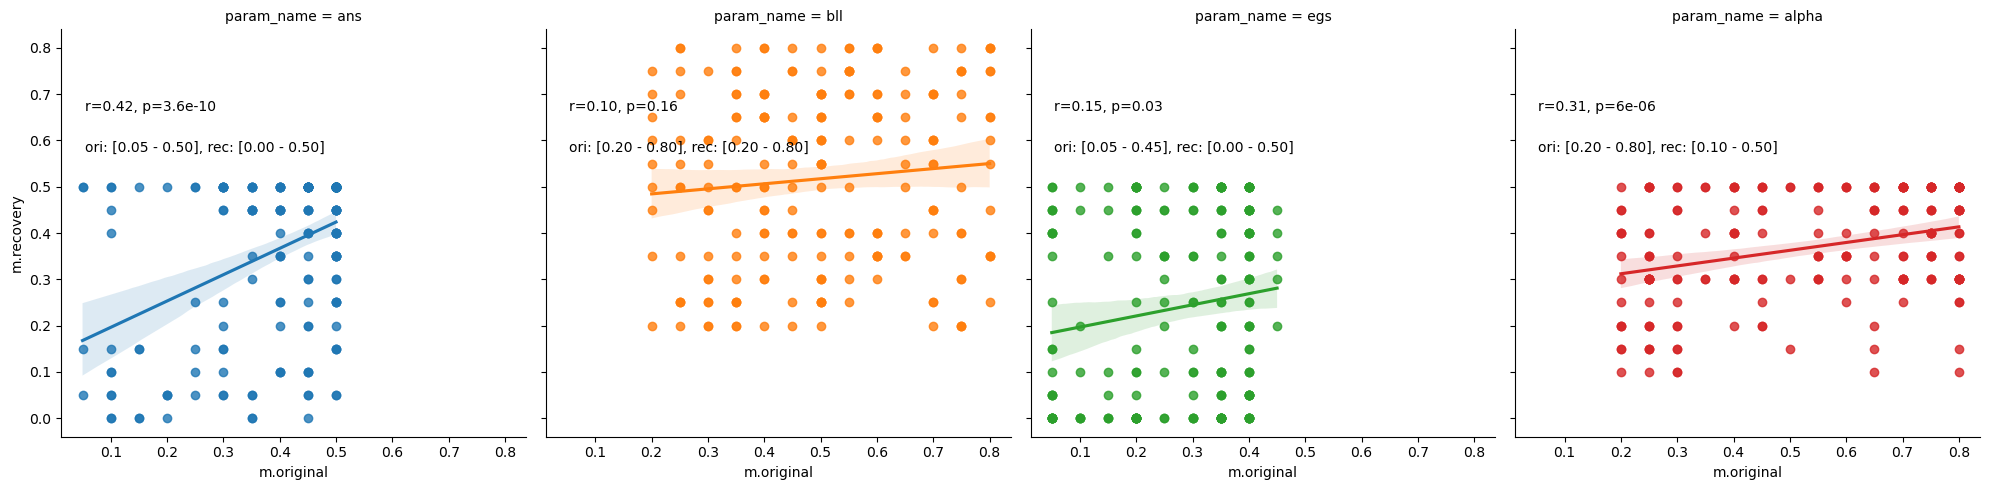

In [5]:
def annotate(data, **kws):
    r, p = stats.pearsonr(data['m.original'], data['m.recovery'])
    ax = plt.gca()
    ax.text(.05, 0.8, 'r={:.2f}, p={:.2g}'.format(r, p), 
            transform=ax.transAxes)
    min1, min2, max1, max2 = data['m.original'].min(), data['m.recovery'].min(), data['m.original'].max(), data['m.recovery'].max()
    ax.text(.05, 0.7, 'ori: [%.2f - %.2f], rec: [%.2f - %.2f]' % (min1, max1, min2, max2), 
            transform=ax.transAxes)

g = sns.lmplot(data=df_recov_best, x='m.original', y='m.recovery', hue='param_name', col='param_name')
g.map_dataframe(annotate)
plt.show()

#### Model Recovery

Compare groud-truth model and recovered model classification

In `actr_maxLL.csv`: `FakeModel` (m.original) indicates the ground truth of model (which model generates this fake subject data). `BestModel` (m.recovered) indicates that if we feed this fake subject data into maxLL pipline, which model label it will spit out. 


In [6]:
# df = save_model_classification(main_dir=main_dir, subject_dir=log_dir, param_list=None)

In [7]:
df1 = pd.read_csv(os.path.join(main_dir, log_dir, 'actr_maxLL.csv'), usecols=['HCPID', 'FakeModel', 'BestModel'])
df1 = df1.rename(columns={'FakeModel':'m.original', 'BestModel':'m.recovered'}).drop_duplicates().reset_index()
df1['m.recovered'] = df1['m.recovered'].replace({'m1':'model1', 'm2':'model2'})
df1['same'] = df1['m.original'] == df1['m.recovered']
dfc = confusion_matrix(df1, 'm.recovered', 'm.original')

In [8]:
dfsame =  pd.DataFrame(df1.groupby('m.original')['m.recovered'].value_counts(normalize=True))
dfsame

m.recovered
m.original m.recovered             
model1     model2          0.517588
           model1          0.482412
model2     model2          0.869347
           model1          0.130653

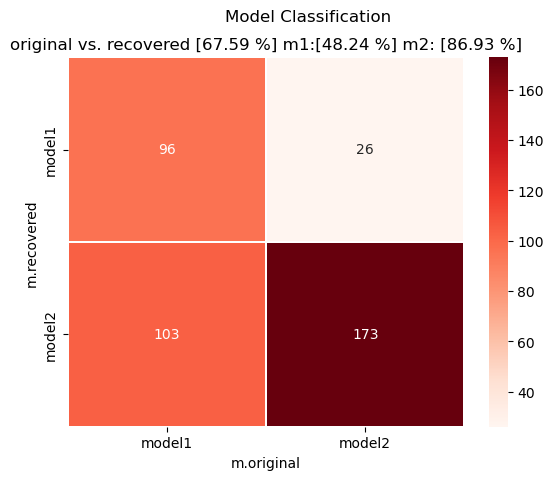

In [9]:
fig, ax = plt.subplots()
fig.suptitle('Model Classification')
ax = sns.heatmap(dfc, annot=True, fmt='d',  linewidth=.2, cmap='Reds')
ax.set_title('original vs. recovered [%.2f %%] m1:[%.2f %%] m2: [%.2f %%]' % (100*df1['same'].mean(), 
          100*dfsame.loc[('model1', 'model1')].values[0], 
          100*dfsame.loc[('model2', 'model2')].values[0]))
plt.show()